In [1]:
import os
import json
import matplotlib.pyplot as plt
from glob import glob
from collections import defaultdict
import pandas as pd
from typing import Dict, List
from pathlib import Path

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 13

In [ ]:
def load_log(run_dir: str) -> Dict:
    log_path = os.path.join(run_dir, "training_log.json")
    if not os.path.exists(log_path):
        raise FileNotFoundError(f"No training_log.json in {run_dir}")
    with open(log_path, "r") as f:
        return json.load(f)

In [ ]:
def get_ablation_name(log: dict, run_dir: str) -> str:
    try:
        cfg = log["config"].get("hparams", {})
        if cfg.get("remove_tactic_feature"):
            return "remove_tactic_feature"
        if cfg.get("remove_node_type"):
            return "remove_node_type"
        if cfg.get("shuffle_edges"):
            return "shuffle_edges"
        if cfg.get("shuffle_tactic_ids"):
            return "shuffle_tactic_ids"
        if cfg.get("shuffle_targets"):
            return "shuffle_targets"
        if cfg.get("mlp_bag_of_tactics"):
            return "mlp_bag_of_tactics"
        return "full_model"
    except:
        pass
    name = run_dir.lower()
    if "mlp" in name:
        return "mlp_bag_of_tactics"
    if "shuffle_edges" in name:
        return "shuffle_edges"
    if "shuffle_targets" in name:
        return "shuffle_targets"
    if "shuffle_tactic_ids" in name:
        return "shuffle_tactic_ids"
    if "remove_node_type" in name:
        return "remove_node_type"
    if "remove_tactic_feature" in name:
        return "remove_tactic_feature"

    return "full_model"


def get_final_val_acc(log: Dict) -> float:
    return log["val_acc"][-1]


Bar Chart

In [5]:
def plot_final_val_acc(results: Dict[str, float]):
    """
    results: dict mapping ablation_name -> final_val_acc
    """
    plt.figure(figsize=(9, 6))
    names = list(results.keys())
    vals = list(results.values())

    plt.bar(names, vals, color='green')
    plt.ylabel("Final Validation Accuracy")
    plt.xticks(rotation=30, ha="right")
    plt.title("Ablation Study – Final Validation Accuracy")
    plt.ylim(0, 1.0)
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    plt.show()


Train-Val Curves

In [6]:
def plot_training_curves(log: Dict, title="Training Curves"):
    train_loss = log["train_loss"]
    val_loss   = log["val_loss"]
    val_acc    = log["val_acc"]

    epochs = range(1, len(train_loss) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    ax[0].plot(epochs, train_loss, label="Train Loss")
    ax[0].plot(epochs, val_loss, label="Val Loss")
    ax[0].set_title("Loss Curves")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Accuracy
    ax[1].plot(epochs, val_acc, label="Val Acc", color="green")
    ax[1].set_title("Validation Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_ylim(0,1)
    ax[1].grid(True, alpha=0.3)

    fig.suptitle(title)
    plt.show()


Scatter Plot

In [7]:
def plot_all_ablation_results(root="runs/"):
    root = Path(root)
    run_dirs = sorted([p for p in root.iterdir() if p.is_dir()])

    results = {} 
    detailed_logs = {} 

    for rd in run_dirs:
        try:
            log = load_log(rd)
        except:
            continue

        ablation = get_ablation_name(log, run_dirs)
        val = get_final_val_acc(log)

        results[ablation] = val
        if ablation not in detailed_logs:
            detailed_logs[ablation] = log

    plot_final_val_acc(results)

    for name, log in detailed_logs.items():
        plot_training_curves(log, title=f"Ablation: {name}")
    
    return results

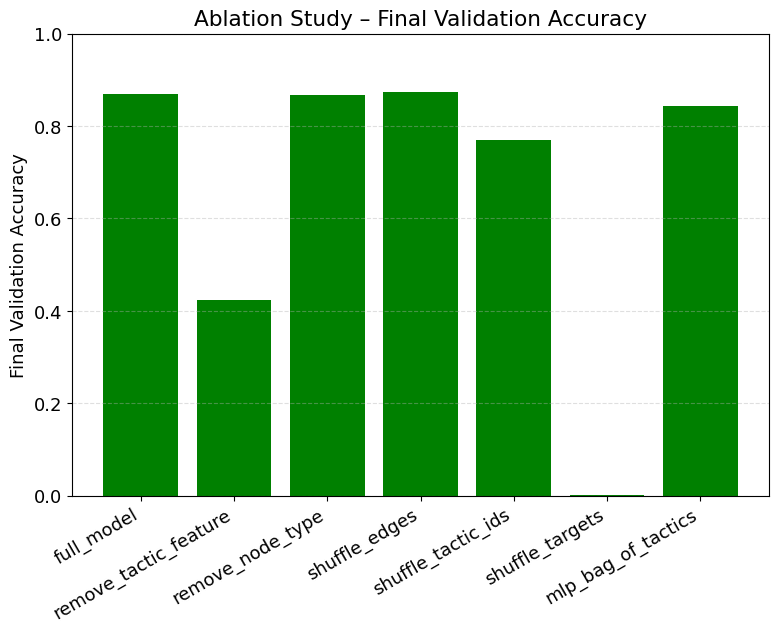

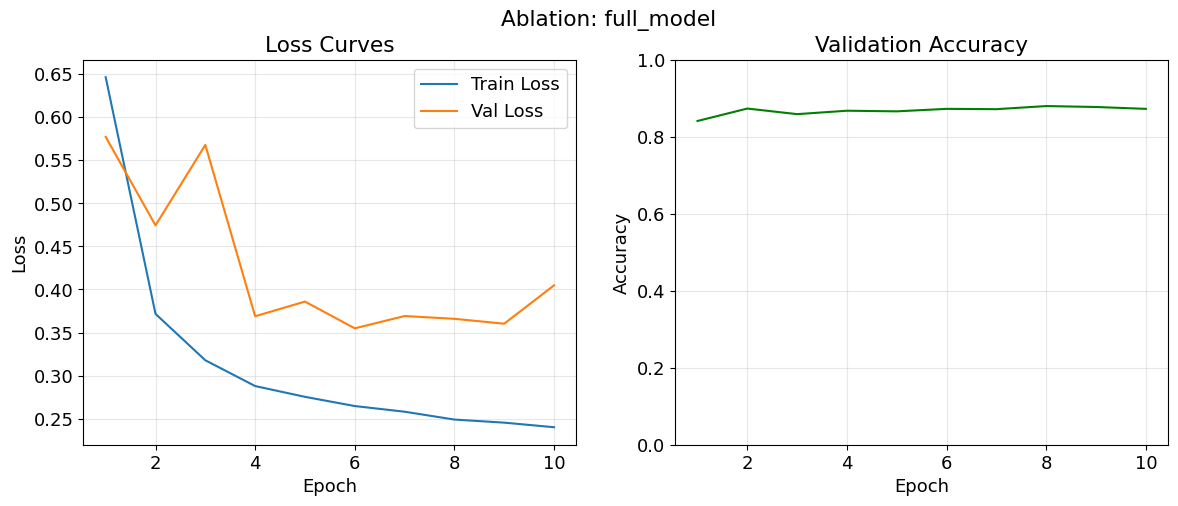

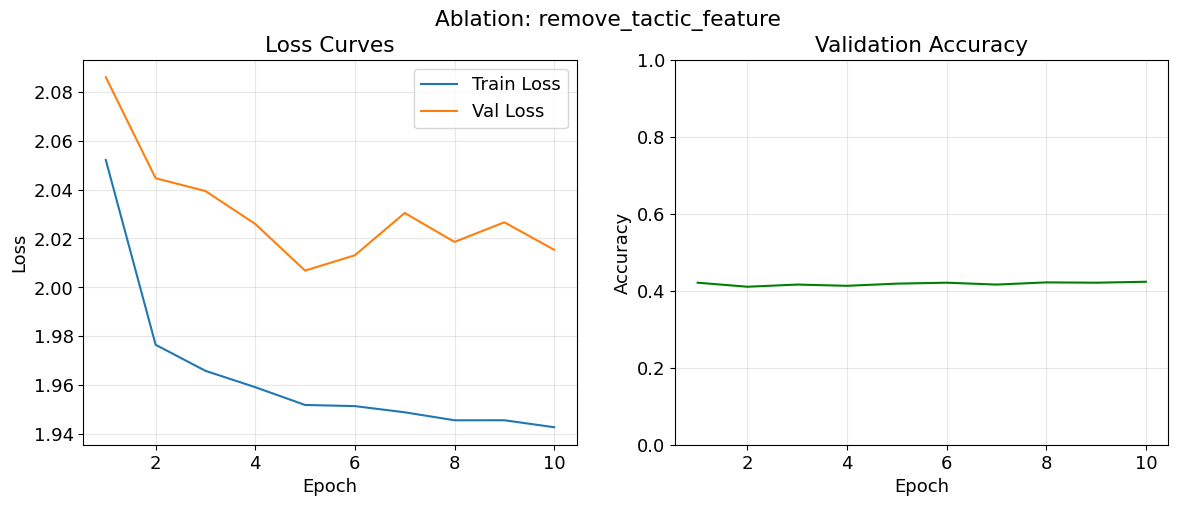

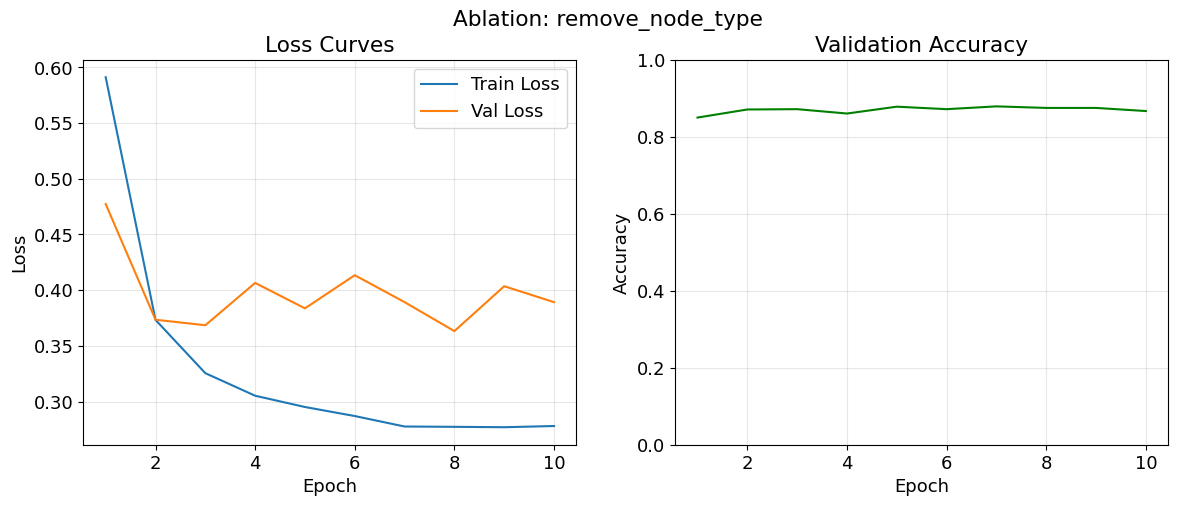

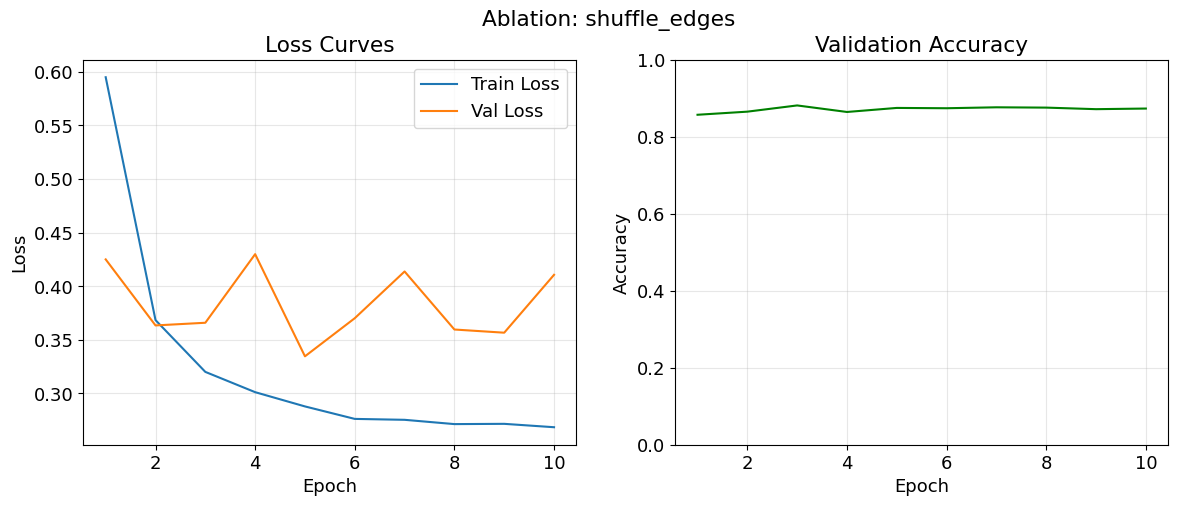

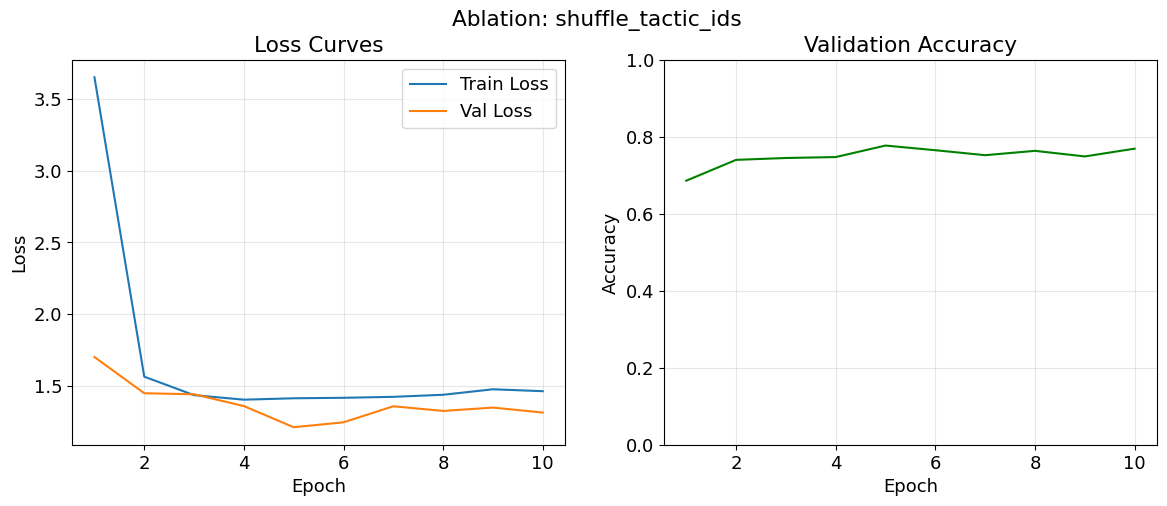

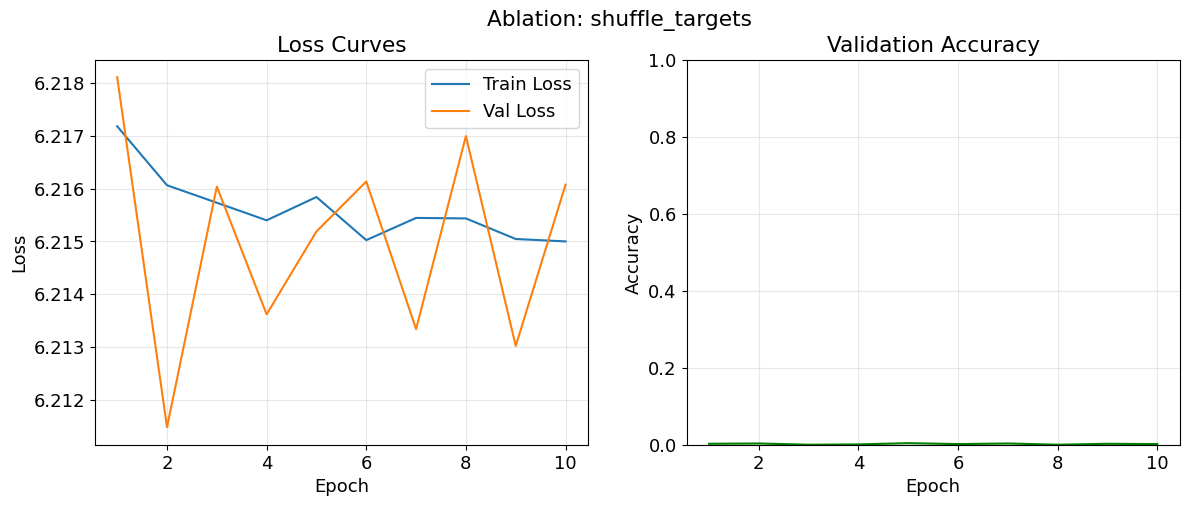

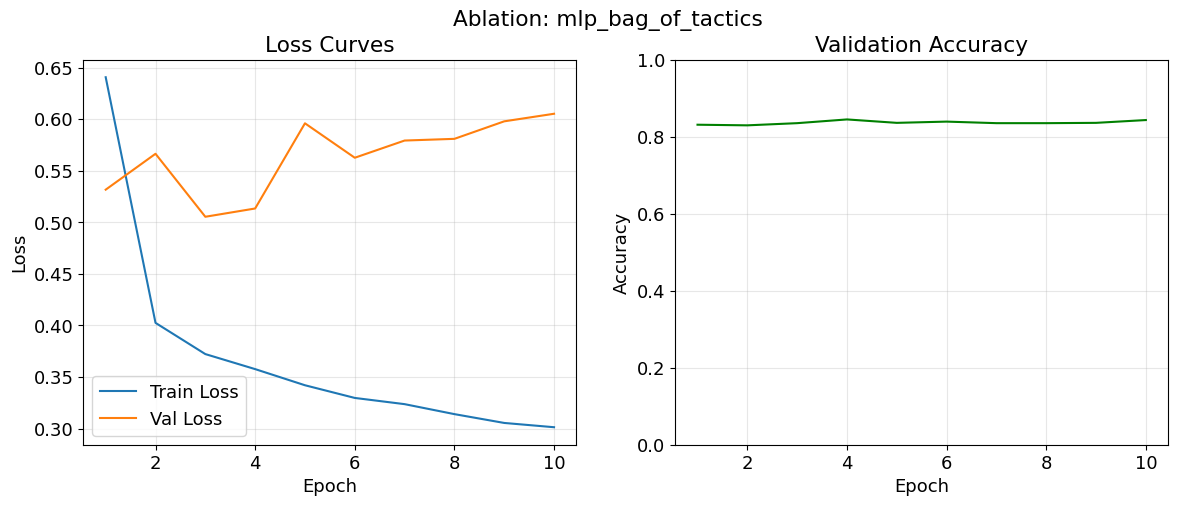

{'full_model': 0.869951534733441,
 'remove_tactic_feature': 0.42326332794830374,
 'remove_node_type': 0.8667205169628432,
 'shuffle_edges': 0.8731825525040388,
 'shuffle_tactic_ids': 0.7689822294022617,
 'shuffle_targets': 0.0016155088852988692,
 'mlp_bag_of_tactics': 0.8432956381260097}

In [8]:
results = plot_all_ablation_results("runs/")
results

In [9]:
def plot_all_val_curves(root):
    run_dirs = [
        os.path.join(root, d)
        for d in os.listdir(root)
        if os.path.isdir(os.path.join(root, d))
    ]

    plt.figure(figsize=(10, 6))

    plotted_any = False

    for run in sorted(run_dirs):
        log_path = os.path.join(run, "training_log.json")
        if not os.path.exists(log_path):
            continue

        with open(log_path, "r") as f:
            log = json.load(f)

        if "val_acc" not in log:
            continue

        val_curve = log["val_acc"]
        if len(val_curve) == 0:
            continue

        # clean label: show directory name only
        label = get_ablation_name(log, run_dirs)

        plt.plot(val_curve, marker="o", linewidth=2, label=label)
        plotted_any = True

    if not plotted_any:
        print("No valid training_log.json files found.")
        return

    plt.title("Validation Accuracy Curves Across Ablations", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Accuracy", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

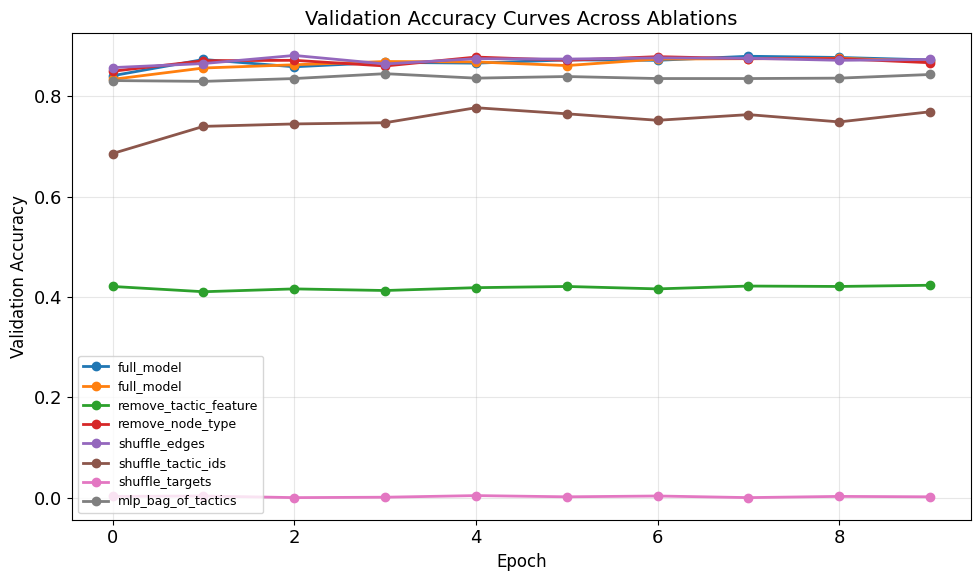

In [10]:
plot_all_val_curves("runs/")